# Classifying Asteroids using Unsupervised Learning Methods

This project will explore different ways unsupervised learning can be used to classify asteroids, using the Nasa: Asteroids Classification dataset on Kaggle, found at URL: https://www.kaggle.com/datasets/lovishbansal123/nasa-asteroids-classification

Note that for this project, I chose to download the .csv file directly to my machine. I've prevented it from uploading to git using .gitignore. If you would like to replicate this code, you'll need to download the csv from the abovementioned kaggle link. 

This project required 3 deliverables:
1. This notebook
2. A video presentation (powerpoint slides will be available on Git)
3. A public GitHub repository, found here: https://github.com/Kate-Zilla/NASA-asteriod-classification 

# Problem Description
The goal of this project is to discover any latent structure among asteroid features, evaluate reconstruction quality across methods using RMSE, and examine clusters for interpretability. Understanding the structure of an asteroid can help with prioritization of additional observations as well as risk triage. 

Import Statements:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial.distance import pdist, squareform
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import TruncatedSVD, PCA, NMF
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import mean_squared_error, silhouette_score, pairwise_distances
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_extraction.text import TfidfVectorizer

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

pd.set_option('display.max_columns', 120)
sns.set_context("notebook")

# EDA: 
Here I will load the data and perform exploratory data analysis.

In [2]:
df = pd.read_csv('nasa.csv')
df.head()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Close Approach Date,Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(kilometers),Miss Dist.(miles),Orbiting Body,Orbit ID,Orbit Determination Date,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-01,788947200000,6.115834,22017.003799,13680.509944,0.419483,163.178711,62753692.0,38993336.0,Earth,17,2017-04-06 08:36:37,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,1995-01-01,788947200000,18.113985,65210.346095,40519.173105,0.383014,148.992630,57298148.0,35603420.0,Earth,21,2017-04-06 08:32:49,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,1698.341531,1995-01-08,789552000000,7.590711,27326.560182,16979.661798,0.050956,19.821890,7622911.5,4736657.5,Earth,22,2017-04-06 09:20:19,0,0.043058,4.557,2458000.5,0.348248,1.458824,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,64.569144,1995-01-15,790156800000,11.173874,40225.948191,24994.839864,0.285322,110.990387,42683616.0,26522368.0,Earth,7,2017-04-06 09:15:49,6,0.005512,5.093,2458000.5,0.216578,1.255903,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-15,790156800000,9.840831,35426.991794,22012.954985,0.407832,158.646713,61010824.0,37910368.0,Earth,25,2017-04-06 08:57:58,1,0.034798,5.154,2458000.5,0.210448,1.225615,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Neo Reference ID              4687 non-null   int64  
 1   Name                          4687 non-null   int64  
 2   Absolute Magnitude            4687 non-null   float64
 3   Est Dia in KM(min)            4687 non-null   float64
 4   Est Dia in KM(max)            4687 non-null   float64
 5   Est Dia in M(min)             4687 non-null   float64
 6   Est Dia in M(max)             4687 non-null   float64
 7   Est Dia in Miles(min)         4687 non-null   float64
 8   Est Dia in Miles(max)         4687 non-null   float64
 9   Est Dia in Feet(min)          4687 non-null   float64
 10  Est Dia in Feet(max)          4687 non-null   float64
 11  Close Approach Date           4687 non-null   object 
 12  Epoch Date Close Approach     4687 non-null   int64  
 13  Rel

In [4]:
df.describe()

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(kilometers),Miss Dist.(miles),Orbit ID,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion
count,4.687000e+03,4.687000e+03,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4.687000e+03,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4.687000e+03,4.687000e+03,4687.000000,4687.000000,4687.000000,4687.000000,4.687000e+03,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4687.000000,4.687000e+03,4687.000000,4687.000000
mean,3.272298e+06,3.272298e+06,22.267865,0.204604,0.457509,204.604203,457.508906,0.127135,0.284283,671.273653,1501.013521,1.179881e+12,13.970811,50294.919829,31251.307268,0.256778,99.886706,3.841347e+07,2.386902e+07,28.300619,3.516962,0.082320,5.056111,2.457724e+06,0.382569,1.400264,13.373844,172.157275,635.582076,0.813383,183.932151,1.987144,2.457728e+06,181.167927,0.738242
std,5.486011e+05,5.486011e+05,2.890972,0.369573,0.826391,369.573402,826.391249,0.229642,0.513496,1212.511199,2711.257465,1.981540e+11,7.293223,26255.601377,16314.209644,0.145798,56.715493,2.181110e+07,1.355279e+07,38.299668,3.078307,0.090300,1.237818,9.202975e+02,0.180444,0.524154,10.936227,103.276777,370.954727,0.242059,103.513035,0.951519,9.442264e+02,107.501623,0.342627
min,2.000433e+06,2.000433e+06,11.160000,0.001011,0.002260,1.010543,2.259644,0.000628,0.001404,3.315431,7.413530,7.889472e+11,0.335504,1207.814804,750.489149,0.000178,0.069194,2.660989e+04,1.653462e+04,1.000000,0.000000,0.000002,2.196000,2.450164e+06,0.007522,0.615920,0.014513,0.001941,176.557161,0.080744,0.006918,0.803765,2.450100e+06,0.003191,0.086285
25%,3.097594e+06,3.097594e+06,20.100000,0.033462,0.074824,33.462237,74.823838,0.020792,0.046493,109.784247,245.485039,1.015574e+12,8.432865,30358.313370,18863.475327,0.133420,51.900211,1.995928e+07,1.240212e+07,9.000000,0.000000,0.014585,4.049500,2.458000e+06,0.240858,1.000635,4.962341,83.081208,365.605031,0.630834,95.625916,1.266059,2.457815e+06,87.006918,0.453289
50%,3.514799e+06,3.514799e+06,21.900000,0.110804,0.247765,110.803882,247.765013,0.068850,0.153954,363.529809,812.877364,1.203062e+12,12.917889,46504.401181,28896.026390,0.265029,103.096123,3.964771e+07,2.463595e+07,16.000000,3.000000,0.047365,5.071000,2.458000e+06,0.372450,1.240981,10.311836,172.625393,504.947292,0.833153,189.761641,1.618195,2.457973e+06,185.718889,0.712946
75%,3.690060e+06,3.690060e+06,24.500000,0.253837,0.567597,253.837029,567.596853,0.157727,0.352688,832.798679,1862.194459,1.355558e+12,18.077649,65079.535405,40437.892430,0.384154,149.435921,5.746863e+07,3.570935e+07,31.000000,6.000000,0.123593,6.019000,2.458000e+06,0.512411,1.678364,19.511681,255.026909,794.195972,0.997227,271.777557,2.451171,2.458108e+06,276.531946,0.984669
max,3.781897e+06,3.781897e+06,32.100000,15.579552,34.836938,15579.552413,34836.938254,9.680682,21.646663,51114.018738,114294.420501,1.473318e+12,44.633747,160681.487851,99841.227826,0.499884,194.454910,7.478160e+07,4.646713e+07,611.000000,9.000000,0.477891,9.025000,2.458020e+06,0.960261,5.072008,75.406667,359.905890,4172.231343,1.299832,359.993098,8.983852,2.458839e+06,359.917991,2.039000


I am starting out here with 40 columns, and over 4600 data points. There are no null values. 

Our Target column will be 'Hazardous', which currently has either 'True' or 'False'. 

Below, I will display the unique values that exist in each column that has dtype == object. 

In [5]:
for c in df.columns:
    if df[c].dtype == 'object':
        print(c, df[c].unique())

Close Approach Date ['1995-01-01' '1995-01-08' '1995-01-15' '1995-01-22' '1995-02-08'
 '1995-02-15' '1995-02-22' '1995-03-08' '1995-03-15' '1995-03-22'
 '1995-04-08' '1995-04-15' '1995-04-22' '1995-05-08' '1995-05-15'
 '1995-05-22' '1995-06-08' '1995-06-15' '1995-06-22' '1995-07-08'
 '1995-07-15' '1995-07-22' '1995-08-08' '1995-08-15' '1995-08-22'
 '1995-09-08' '1995-09-15' '1995-09-22' '1995-10-08' '1995-10-15'
 '1995-10-22' '1995-11-08' '1995-11-15' '1995-11-22' '1995-12-08'
 '1995-12-15' '1995-12-22' '1996-01-08' '1996-01-15' '1996-01-22'
 '1996-02-08' '1996-02-15' '1996-02-22' '1996-03-08' '1996-03-22'
 '1996-04-08' '1996-04-15' '1996-04-22' '1996-05-08' '1996-05-15'
 '1996-05-22' '1996-06-08' '1996-06-15' '1996-06-22' '1996-07-08'
 '1996-07-15' '1996-07-22' '1996-08-08' '1996-08-15' '1996-08-22'
 '1996-09-08' '1996-09-15' '1996-09-22' '1996-10-08' '1996-10-15'
 '1996-10-22' '1996-11-08' '1996-11-15' '1996-11-22' '1996-12-08'
 '1996-12-15' '1996-12-22' '1997-01-08' '1997-01-15' '19

I will immediate drop the Orbiting Body & Equinox columns as they are constant. 

In [6]:
df = df.drop(['Orbiting Body','Equinox'],axis=1)
df.head(2)

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Close Approach Date,Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(kilometers),Miss Dist.(miles),Orbit ID,Orbit Determination Date,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-01,788947200000,6.115834,22017.003799,13680.509944,0.419483,163.178711,62753692.0,38993336.0,17,2017-04-06 08:36:37,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,1995-01-01,788947200000,18.113985,65210.346095,40519.173105,0.383014,148.992630,57298148.0,35603420.0,21,2017-04-06 08:32:49,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,False


I want to see ALL the orbit determination dates, so I will display them here:

In [7]:
print(df['Orbit Determination Date'].unique)

<bound method Series.unique of 0       2017-04-06 08:36:37
1       2017-04-06 08:32:49
2       2017-04-06 09:20:19
3       2017-04-06 09:15:49
4       2017-04-06 08:57:58
               ...         
4682    2017-04-06 08:24:07
4683    2017-04-06 08:23:58
4684    2017-04-06 08:23:43
4685    2017-04-06 08:23:42
4686    2017-04-29 06:18:33
Name: Orbit Determination Date, Length: 4687, dtype: object>


It appears they are all gathered in the same month of the same year, so I will drop that column as well

In [8]:
df = df.drop(['Orbit Determination Date'], axis=1)
df.head(2)

,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Close Approach Date,Epoch Date Close Approach,Relative Velocity km per sec,Relative Velocity km per hr,Miles per hour,Miss Dist.(Astronomical),Miss Dist.(lunar),Miss Dist.(kilometers),Miss Dist.(miles),Orbit ID,Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,1995-01-01,788947200000,6.115834,22017.003799,13680.509944,0.419483,163.178711,62753692.0,38993336.0,17,5,0.025282,4.634,2458000.5,0.425549,1.407011,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,1995-01-01,788947200000,18.113985,65210.346095,40519.173105,0.383014,148.992630,57298148.0,35603420.0,21,3,0.186935,5.457,2458000.5,0.351674,1.107776,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,False


I am going to also drop the reference ID and name columns as they do not give me information ABOUT the asteroids. I will also drop columns consisting of redundant measurements: 
 - Est Dia im KM(min)
 - Est Dia in KM(max)
 - Est Dia in Miles(min)
 - Est Dia in Miles(max)
 - Est Dia in Feet(min)
 - Est Dia in Feet(max)

 (This leaves estimated diameter in meters)
 - Close Approach Date
 - Epoch Date Close Approach

 (I am dropping timestamps as they represent when something happened, not how it relates structurally to the other features)

 (This leaves Epoch Date Close Approach, which is the close apporach date in UNIX timestamp)
 - Relative Velocity km per hr
 - Miles per hour

 (This leaves Relative Velocity km per sec)
 - Miss Dist. (Astronomical)
 - Miss Dist. (kilometers)
 - Miss Dist. (miles)

 (This leaves Miss Dist. (lunar); LDs are the most appropriate unit for measuring asteroid distance from Earth)
 - Orbit ID

 (Orbit ID can be dropped as is essentially a verion number of a calculation/published solution by NASA)


In [9]:
df = df.drop(['Neo Reference ID','Name'],axis = 1)
df = df.drop(['Epoch Date Close Approach','Orbit ID'], axis=1)
df = df.drop(['Est Dia in KM(min)','Est Dia in KM(max)'],axis = 1)
df = df.drop(['Est Dia in Miles(min)','Est Dia in Miles(max)'],axis = 1)
df = df.drop(['Est Dia in Feet(min)','Est Dia in Feet(max)'],axis = 1)
df = df.drop(['Close Approach Date','Relative Velocity km per hr','Miles per hour'],axis = 1)
df = df.drop(['Miss Dist.(Astronomical)','Miss Dist.(kilometers)','Miss Dist.(miles)'],axis = 1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Absolute Magnitude            4687 non-null   float64
 1   Est Dia in M(min)             4687 non-null   float64
 2   Est Dia in M(max)             4687 non-null   float64
 3   Relative Velocity km per sec  4687 non-null   float64
 4   Miss Dist.(lunar)             4687 non-null   float64
 5   Orbit Uncertainity            4687 non-null   int64  
 6   Minimum Orbit Intersection    4687 non-null   float64
 7   Jupiter Tisserand Invariant   4687 non-null   float64
 8   Epoch Osculation              4687 non-null   float64
 9   Eccentricity                  4687 non-null   float64
 10  Semi Major Axis               4687 non-null   float64
 11  Inclination                   4687 non-null   float64
 12  Asc Node Longitude            4687 non-null   float64
 13  Orb

I am now going to map my 'Hazardous' column to 1s and 0s instead of True and False to allow for the use of numerical algorithms, including Agglormerative Clustering and NMF. 

In [11]:
df['Hazardous'] = df['Hazardous'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Absolute Magnitude            4687 non-null   float64
 1   Est Dia in M(min)             4687 non-null   float64
 2   Est Dia in M(max)             4687 non-null   float64
 3   Relative Velocity km per sec  4687 non-null   float64
 4   Miss Dist.(lunar)             4687 non-null   float64
 5   Orbit Uncertainity            4687 non-null   int64  
 6   Minimum Orbit Intersection    4687 non-null   float64
 7   Jupiter Tisserand Invariant   4687 non-null   float64
 8   Epoch Osculation              4687 non-null   float64
 9   Eccentricity                  4687 non-null   float64
 10  Semi Major Axis               4687 non-null   float64
 11  Inclination                   4687 non-null   float64
 12  Asc Node Longitude            4687 non-null   float64
 13  Orb

Furthermore, Aphelion Dist, Perihelion Dist, and Semi Major Axis are all mathematically related, so I will see if they have strong correlations, below: 

In [12]:
df[['Semi Major Axis', 'Aphelion Dist', 'Perihelion Distance']].corr()

,Semi Major Axis,Aphelion Dist,Perihelion Distance
Semi Major Axis,1.000000,0.975326,0.496847
Aphelion Dist,0.975326,1.000000,0.292995
Perihelion Distance,0.496847,0.292995,1.000000


Aphelion Dist seems to have a strong correlation with semi-major axis, so i will go ahead and drop it. 

In [13]:
df = df.drop(['Aphelion Dist'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Absolute Magnitude            4687 non-null   float64
 1   Est Dia in M(min)             4687 non-null   float64
 2   Est Dia in M(max)             4687 non-null   float64
 3   Relative Velocity km per sec  4687 non-null   float64
 4   Miss Dist.(lunar)             4687 non-null   float64
 5   Orbit Uncertainity            4687 non-null   int64  
 6   Minimum Orbit Intersection    4687 non-null   float64
 7   Jupiter Tisserand Invariant   4687 non-null   float64
 8   Epoch Osculation              4687 non-null   float64
 9   Eccentricity                  4687 non-null   float64
 10  Semi Major Axis               4687 non-null   float64
 11  Inclination                   4687 non-null   float64
 12  Asc Node Longitude            4687 non-null   float64
 13  Orb

Here I will split out features & target columns, then create a correlation matrix of the features, as well as a heatmap. 

In [14]:
features = df.drop(columns=['Hazardous'])
target = df['Hazardous']

In [15]:
features.corr()

,Absolute Magnitude,Est Dia in M(min),Est Dia in M(max),Relative Velocity km per sec,Miss Dist.(lunar),Orbit Uncertainity,Minimum Orbit Intersection,Jupiter Tisserand Invariant,Epoch Osculation,Eccentricity,Semi Major Axis,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Perihelion Time,Mean Anomaly,Mean Motion
Absolute Magnitude,1.000000,-0.613482,-0.613482,-0.376853,-0.339117,0.677764,-0.488235,0.238702,-0.116087,-0.361359,-0.212437,-0.459632,-0.011470,-0.206774,0.086966,0.031784,-0.115855,-0.049401,0.195652
Est Dia in M(min),-0.613482,1.000000,1.000000,0.242141,0.188027,-0.399488,0.257904,-0.133582,0.061582,0.216623,0.121224,0.259450,0.036558,0.118314,-0.071866,-0.019577,0.062167,0.031455,-0.104350
Est Dia in M(max),-0.613482,1.000000,1.000000,0.242141,0.188027,-0.399488,0.257904,-0.133582,0.061582,0.216623,0.121224,0.259450,0.036558,0.118314,-0.071866,-0.019577,0.062167,0.031455,-0.104350
Relative Velocity km per sec,-0.376853,0.242141,0.242141,1.000000,0.351694,-0.202234,0.076306,-0.052294,0.020194,0.495053,0.014351,0.514657,-0.021301,0.017961,-0.506978,-0.002913,0.020006,0.017685,0.022452
Miss Dist.(lunar),-0.339117,0.188027,0.188027,0.351694,1.000000,-0.326158,0.351981,0.093969,0.193944,-0.005627,-0.112158,0.255828,-0.023033,-0.109888,-0.079937,-0.021483,0.189409,-0.010157,0.104642
Orbit Uncertainity,0.677764,-0.399488,-0.399488,-0.202234,-0.326158,1.000000,-0.267524,-0.008992,-0.331558,-0.088029,0.043902,-0.228806,-0.009618,0.047535,0.107946,0.016307,-0.325784,-0.059396,-0.023776
Minimum Orbit Intersection,-0.488235,0.257904,0.257904,0.076306,0.351981,-0.267524,1.000000,-0.305849,0.081155,0.093795,0.288947,0.439867,-0.008963,0.279885,0.299991,-0.029130,0.080592,-0.013336,-0.290538
Jupiter Tisserand Invariant,0.238702,-0.133582,-0.133582,-0.052294,0.093969,-0.008992,-0.305849,1.000000,0.051062,-0.478341,-0.930103,-0.037366,0.018413,-0.893517,-0.537884,0.064496,0.051994,0.030972,0.992680
Epoch Osculation,-0.116087,0.061582,0.061582,0.020194,0.193944,-0.331558,0.081155,0.051062,1.000000,-0.067312,-0.057730,0.015879,0.017782,-0.056653,0.000093,-0.006703,0.977613,0.036881,0.045812
Eccentricity,-0.361359,0.216623,0.216623,0.495053,-0.005627,-0.088029,0.093795,-0.478341,-0.067312,1.000000,0.541271,0.039018,-0.015413,0.548521,-0.412612,-0.003210,-0.064366,0.026161,-0.394860


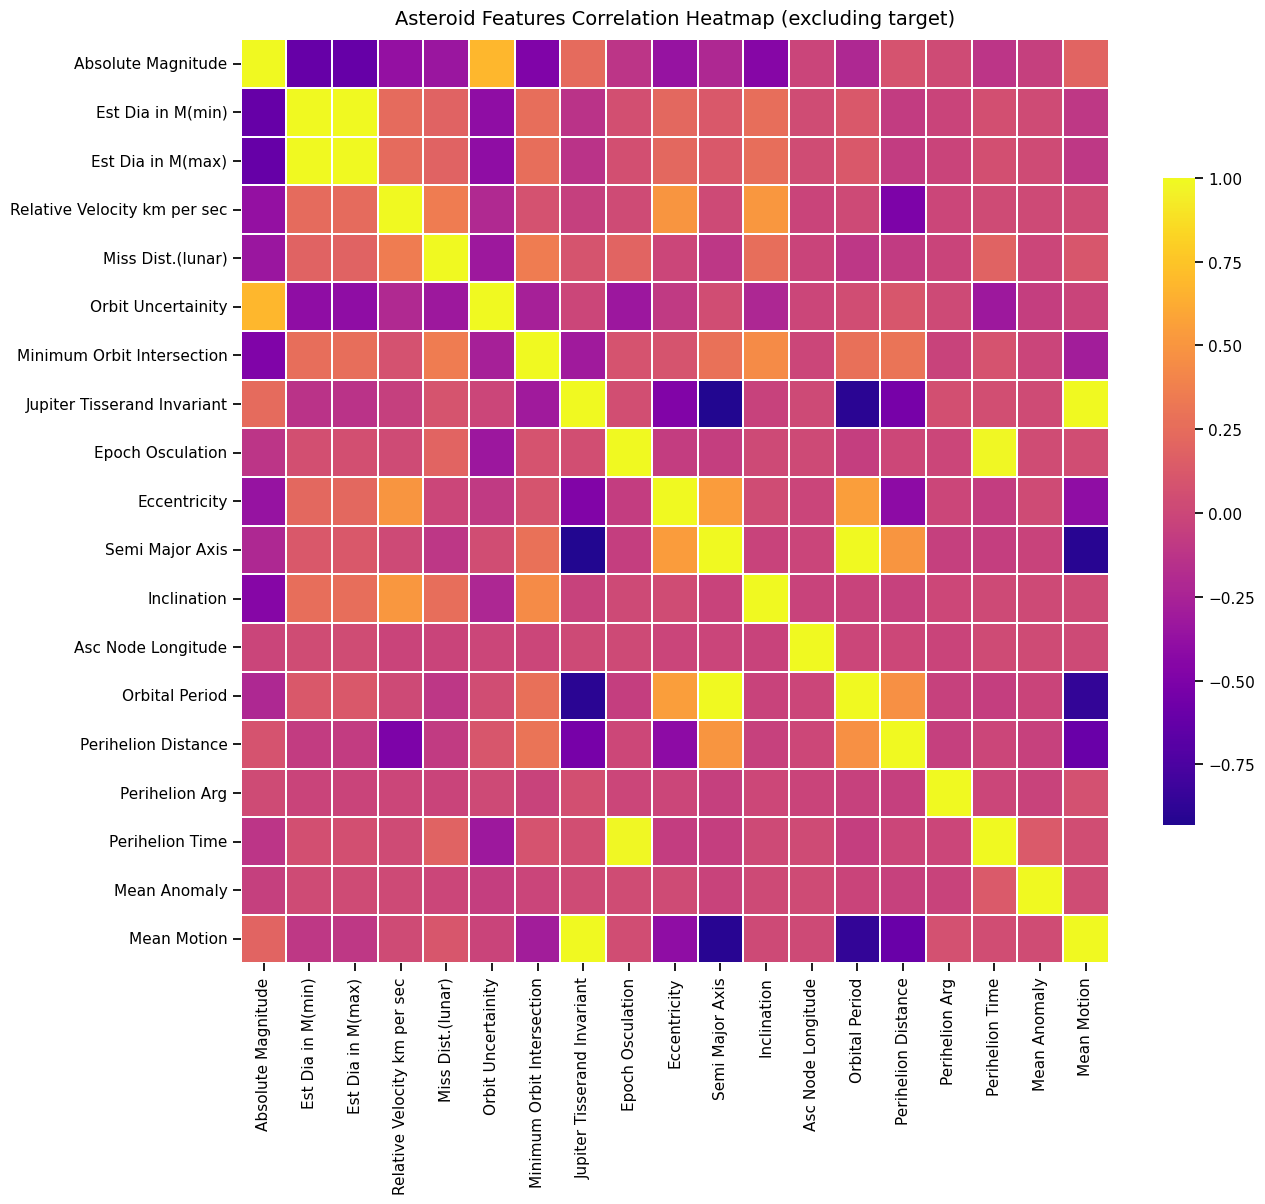

In [16]:
corr_matrix = features.corr()

plt.figure(figsize=(14,12))
sns.heatmap(
    corr_matrix,
    cmap='plasma',
    center = 0,
    square=False,
    linewidths=0.3,
    cbar_kws={'shrink':0.7},
)
plt.title("Asteroid Features Correlation Heatmap (excluding target)", fontsize=14, pad=11)
plt.show()

Here I am seeing strong correlations between:
1. Orbital Period & Semi-Major Axis
2. Epoch Osculation & Perihelion Time
3. Jupiter Tisserand Invariant & Mean Motion

After some research, these can be explained by:
1. Kepler's Third Law of Planetary Motion (https://science.nasa.gov/resource/orbits-and-keplers-laws/)
2. Definition of Mean Anamoly: (https://en.wikipedia.org/wiki/Mean_anomaly?utm_source=chatgpt.com)
3. The definition of the Tissarand Invariant/Parameter itself: (https://en.wikipedia.org/wiki/Tisserand%27s_parameter)


Of these, I will drop the following features:
- orbital period, because it is directly derived from the semi-major axis
- epoch osculation because it is linearly related to perihelion time
- mean motion, as it is a mathematical derivative of the semi-major axis, while the Jupiter Tisserand holds a greater depth of information


In [ ]:
df= df.drop(['Orbital Period', 'Epoch Osculation', 'Mean Motion'], axis=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Absolute Magnitude            4687 non-null   float64
 1   Est Dia in M(min)             4687 non-null   float64
 2   Est Dia in M(max)             4687 non-null   float64
 3   Relative Velocity km per sec  4687 non-null   float64
 4   Miss Dist.(lunar)             4687 non-null   float64
 5   Orbit Uncertainity            4687 non-null   int64  
 6   Minimum Orbit Intersection    4687 non-null   float64
 7   Jupiter Tisserand Invariant   4687 non-null   float64
 8   Eccentricity                  4687 non-null   float64
 9   Semi Major Axis               4687 non-null   float64
 10  Inclination                   4687 non-null   float64
 11  Asc Node Longitude            4687 non-null   float64
 12  Perihelion Distance           4687 non-null   float64
 13  Per

There is also the high correlation between minimum estimated diameter and maximum estimated diameter. Since they are both calculated the same, using a standard uncertanty based on unknown albedo, i will replace both columns with their mean. 

In [19]:
df['Est Dia Mean'] = df[['Est Dia in M(min)', 'Est Dia in M(max)']].mean(axis=1)
df.drop(columns=['Est Dia in M(min)', 'Est Dia in M(max)'], inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Absolute Magnitude            4687 non-null   float64
 1   Relative Velocity km per sec  4687 non-null   float64
 2   Miss Dist.(lunar)             4687 non-null   float64
 3   Orbit Uncertainity            4687 non-null   int64  
 4   Minimum Orbit Intersection    4687 non-null   float64
 5   Jupiter Tisserand Invariant   4687 non-null   float64
 6   Eccentricity                  4687 non-null   float64
 7   Semi Major Axis               4687 non-null   float64
 8   Inclination                   4687 non-null   float64
 9   Asc Node Longitude            4687 non-null   float64
 10  Perihelion Distance           4687 non-null   float64
 11  Perihelion Arg                4687 non-null   float64
 12  Perihelion Time               4687 non-null   float64
 13  Mea

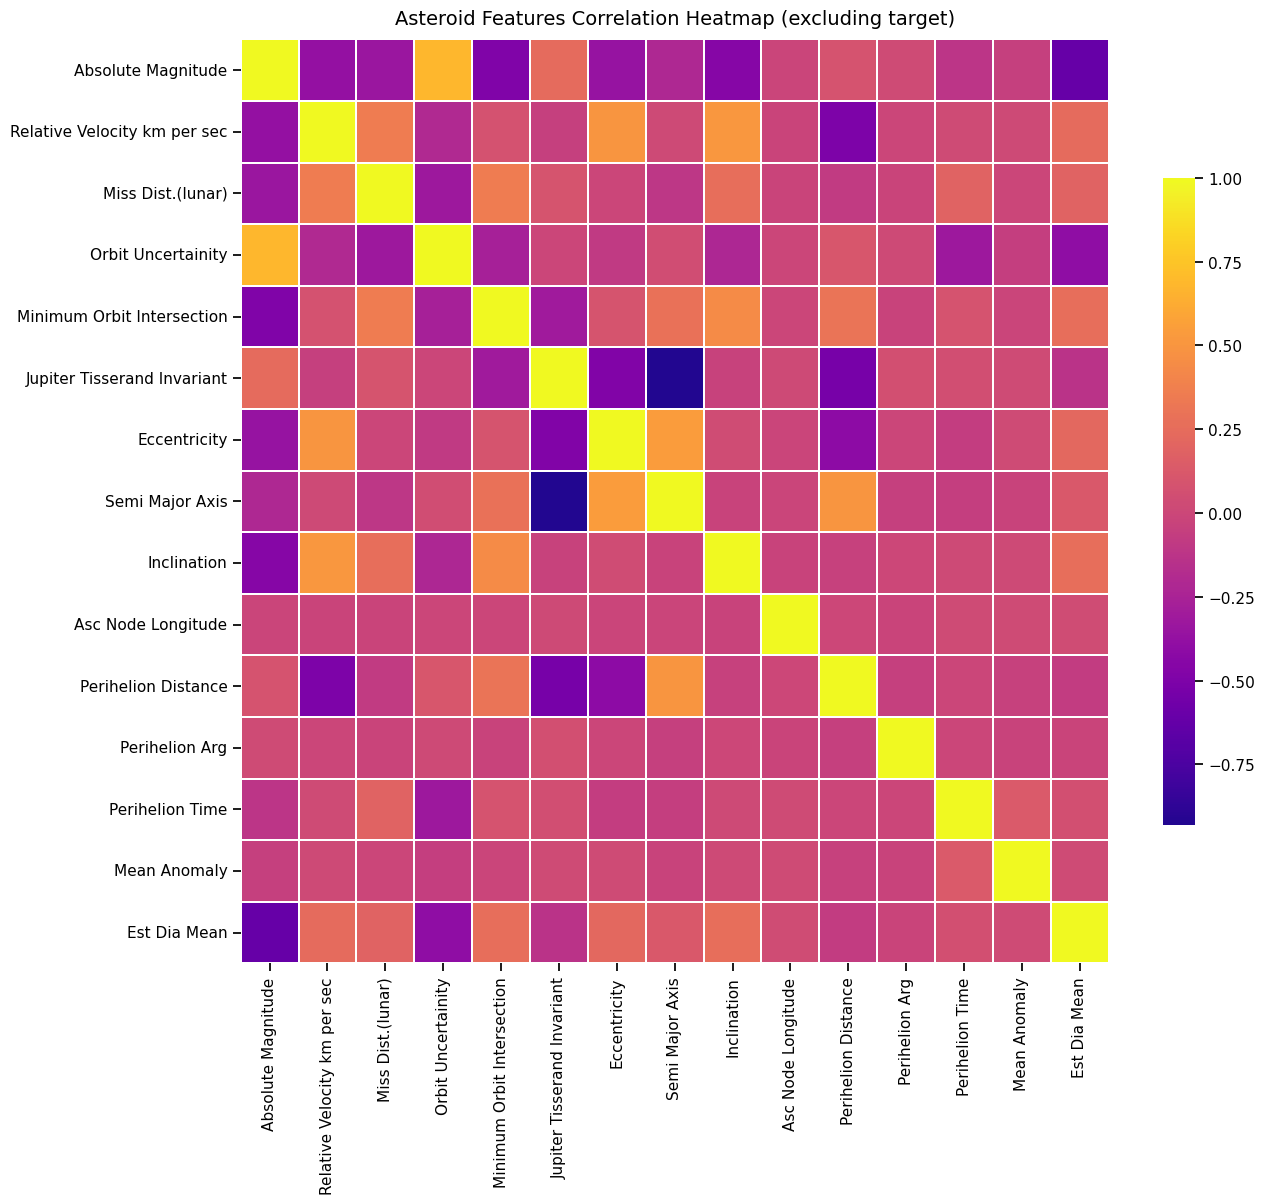

In [21]:
#redefine just to have it
features = df.drop(columns=['Hazardous'])
target = df['Hazardous']


#make a new correlation heatmap to be sure EDA & data cleaning were successful
corr_matrix = features.corr()

plt.figure(figsize=(14,12))
sns.heatmap(
    corr_matrix,
    cmap='plasma',
    center = 0,
    square=False,
    linewidths=0.3,
    cbar_kws={'shrink':0.7},
)
plt.title("Asteroid Features Correlation Heatmap (excluding target)", fontsize=14, pad=11)
plt.show()


In [22]:
#just to check
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4687 entries, 0 to 4686
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Absolute Magnitude            4687 non-null   float64
 1   Relative Velocity km per sec  4687 non-null   float64
 2   Miss Dist.(lunar)             4687 non-null   float64
 3   Orbit Uncertainity            4687 non-null   int64  
 4   Minimum Orbit Intersection    4687 non-null   float64
 5   Jupiter Tisserand Invariant   4687 non-null   float64
 6   Eccentricity                  4687 non-null   float64
 7   Semi Major Axis               4687 non-null   float64
 8   Inclination                   4687 non-null   float64
 9   Asc Node Longitude            4687 non-null   float64
 10  Perihelion Distance           4687 non-null   float64
 11  Perihelion Arg                4687 non-null   float64
 12  Perihelion Time               4687 non-null   float64
 13  Mea

Here's a histogram showing the remaining features:

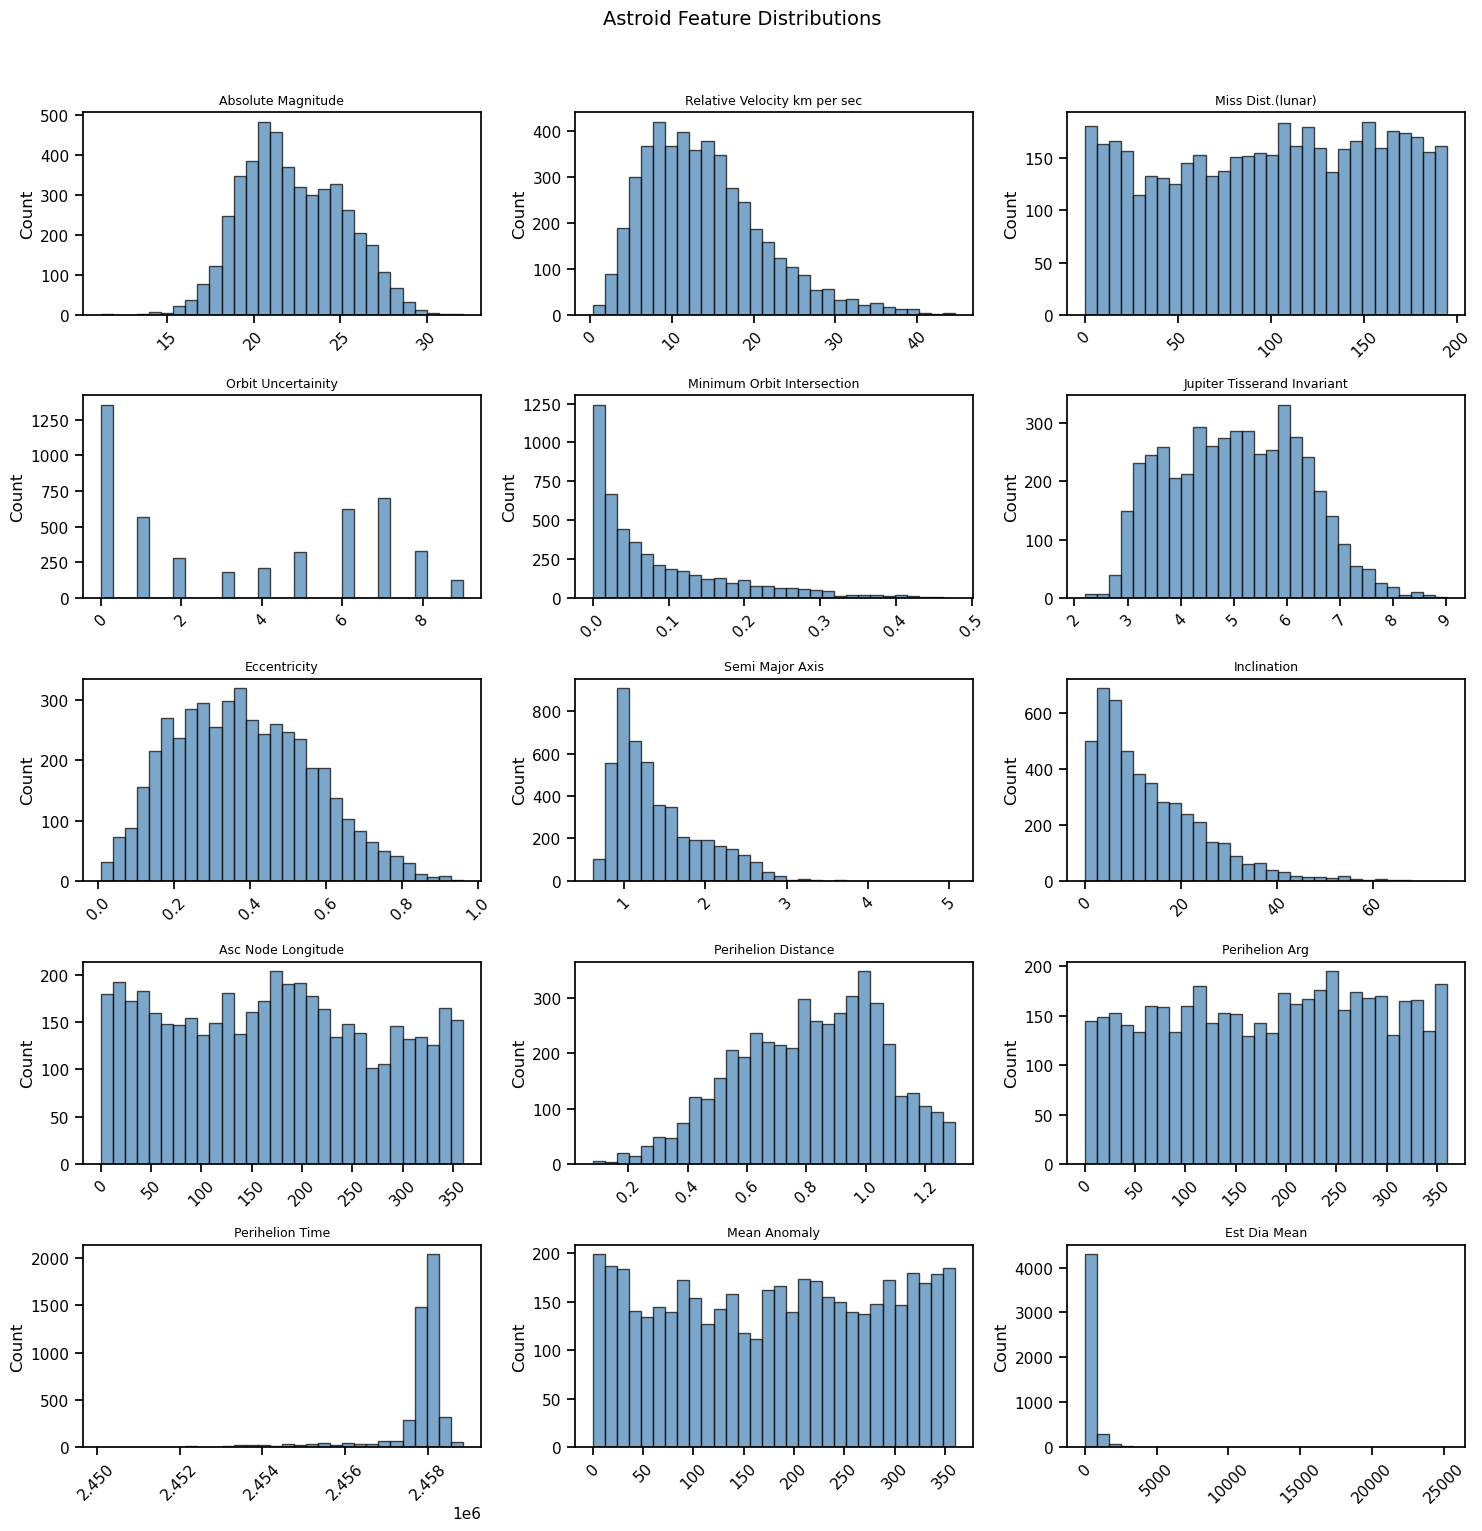

In [23]:
ncols = 3
nrows = -(-len(features.columns) // ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 3))
axes = axes.flatten()

for ax, col in zip(axes, features.columns):
    ax.hist(features[col], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    ax.set_title(col, fontsize=9)
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_ylabel('Count')

fig.suptitle("Astroid Feature Distributions", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


# PCA:
Here I will perform principal component analysis on this cleaned data. 

In [24]:
#I'll start by scaling my features:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

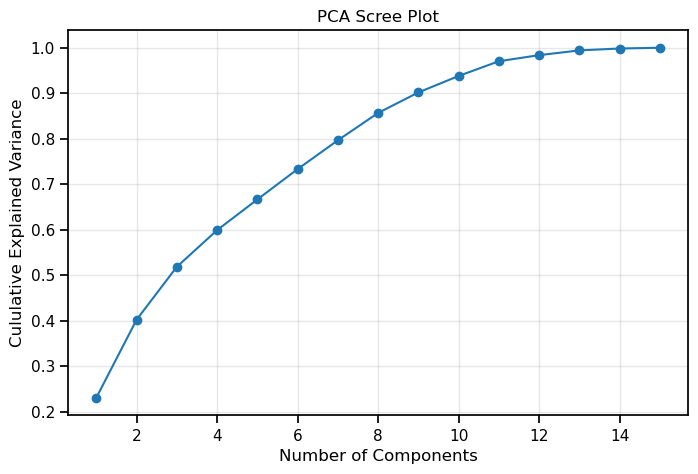

Components that explain 90% of variance: 9


In [25]:
#now I'll fit PCA and inspect the resulting explained variance:
pca = PCA(n_components=features.shape[1]) #full decomp
features_pca = pca.fit_transform(features_scaled)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

#make a plot
plt.figure(figsize=(8,5))
plt.plot(range(1,len(explained)+1), cum_explained, marker = 'o')
plt.xlabel('Number of Components')
plt.ylabel('Cululative Explained Variance')
plt.title('PCA Scree Plot')
plt.grid(alpha=0.3)
plt.show()
print(F"Components that explain 90% of variance: {np.argmax(cum_explained >= 0.90)+1}")


The above output shows that I can reduce dimensionality to 9 from my current 15 features. Next, I'll go ahead and project onto those top 9 PCs. 

In [26]:
pca = PCA(n_components=9)
top_9_features_pca = pca.fit_transform(features_scaled)

In [28]:
top_9_features_pca.shape

(4687, 9)

this shape shows I've reduced my data down to the 9 components. each row is an asteroid, each column is a component. 